
# <center>Estudio celulas de cancer</center>
# <center>con distintos algoritmos de clasificacion</center>

**Índice**   
1. [KNN](#id1)
2. [Arbol de decisión](#id2)
3. [SVM](#id3)
4. [Regresión Logística](#id4)
5. [Random Forest](#id5)
6. [XGBoost](#id6)

Carguemos las librerías necesarias

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBRegressor, XGBClassifier

from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import itertools

### Acerca del set de datos

El archivo ID contiene los identificadores del paciente. Las características de las muestras de las células de cada paciente están contenidas en los campos Clump to Mit. Los valores van del 1 al 10, siendo 1 el más cerca a benigno.

El campo Class contiene el diagnóstico, como se confirmó por procedimientos médicos separados, si son las muestras benignas o no (valor = 2) o maligno (valor = 4).

Miremos a la distribución de las clases basadas en el grosor y uniformidad del tamaña de la célula:

Descarguemos el set de datos. Para descargar los datos, utilizaremos !wget desde IBM Object Storage.

In [2]:
#!wget -O teleCust1000t.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv

# Con 1 vez que se haga vale, por eso esta comentado
# import wget
# url= 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv'
# filename=wget.download(url)
# filename

__¿Sabías?__ Cuando se trata de Machine Learning, seguro trabajarás con grandes datasets (juego de datos). Entonces, ¿dónde podrás guardar esos datos? IBM ofrece una oportunidad única para las empresas, con 10 Tb de IBM Cloud Object Storage: [Registrate ahora gratuitamente](http://cocl.us/ML0101EN-IBM-Offer-CC)

### Cargar Datos a partir de un archivo CSV (Valores Delimitados por Coma)  

In [3]:
df = pd.read_csv("~/Desktop/MLandPython/dataset archive/cell_samples.csv", delimiter=",")
print(df.shape)
df[0:5]

(699, 11)


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Visualización de Datos y Análisis 



#### Veamos cuántos de cada clase están en nuestro set de datos 

In [4]:
# Variables categoricas
# Esto saca cuantos valores por cada categoria de una variable categorica/columna
# print(df['Clump'].value_counts(), df['UnifSize'].value_counts(),df['UnifShape'].value_counts())
# Otra forma de verlo es con histogramas, abajo

Puedes explorar fácilmente tus datos utilizando técnicas de visualización:

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'Clump'}>,
        <AxesSubplot:title={'center':'UnifSize'}>],
       [<AxesSubplot:title={'center':'UnifShape'}>,
        <AxesSubplot:title={'center':'MargAdh'}>,
        <AxesSubplot:title={'center':'SingEpiSize'}>],
       [<AxesSubplot:title={'center':'BlandChrom'}>,
        <AxesSubplot:title={'center':'NormNucl'}>,
        <AxesSubplot:title={'center':'Mit'}>],
       [<AxesSubplot:title={'center':'Class'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

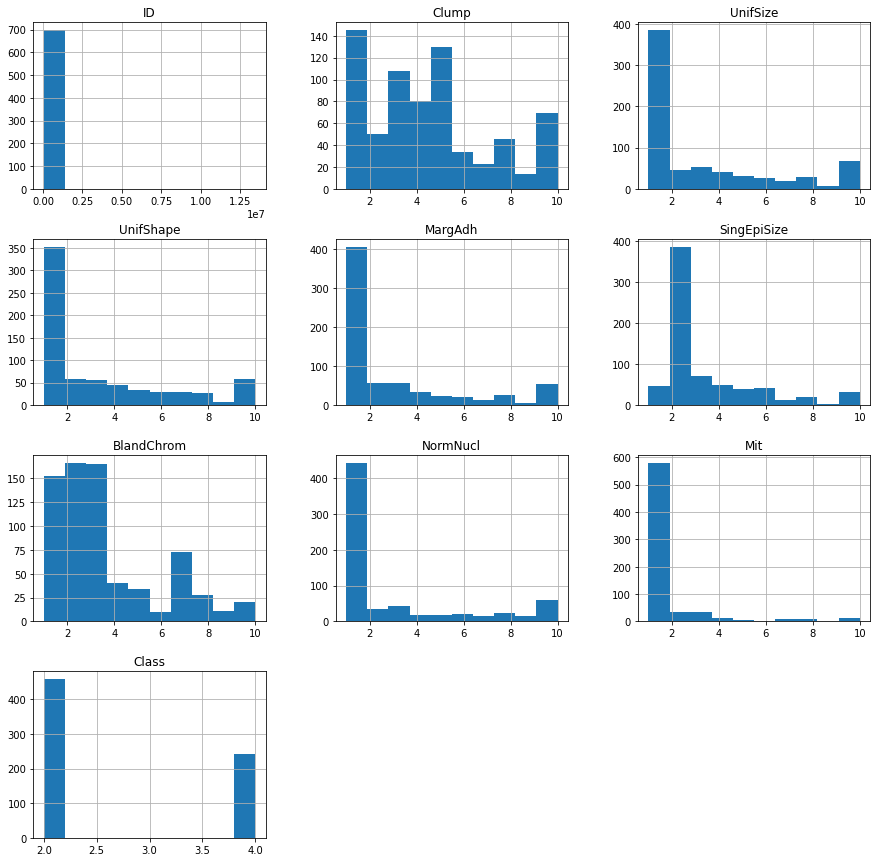

In [5]:
# Variables numericas y categoricas

# Esto imprime todos los histogramas de las columnas a la vez, con el parámetro figsize he controlado el tamaño
df.hist(figsize=(15, 15))


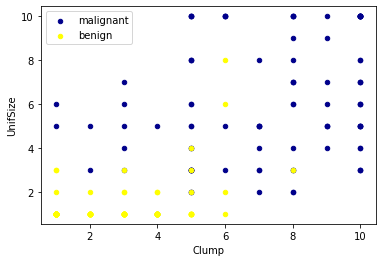

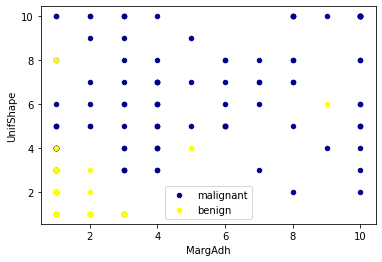

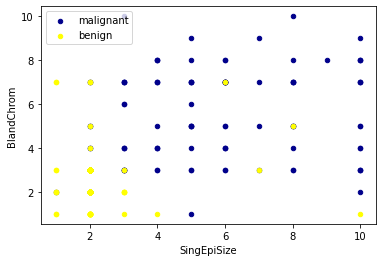

In [6]:
# También puedo ver cada variable indep (de 2 en 2) con respecto a la ver dep o target
# Se ve que están mezclados aunque también separados

ax = df[df['Class'] == 4][0:100].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
df[df['Class'] == 2][0:100].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()
ax = df[df['Class'] == 4][0:100].plot(kind='scatter', x='MargAdh', y='UnifShape', color='DarkBlue', label='malignant');
df[df['Class'] == 2][0:100].plot(kind='scatter', x='MargAdh', y='UnifShape', color='Yellow', label='benign', ax=ax);
plt.show()
ax = df[df['Class'] == 4][0:100].plot(kind='scatter', x='SingEpiSize', y='BlandChrom', color='DarkBlue', label='malignant');
df[df['Class'] == 2][0:100].plot(kind='scatter', x='SingEpiSize', y='BlandChrom', color='Yellow', label='benign', ax=ax);
plt.show()

# Pre-procesamiento

Utilizando <b>my_data</b> como los datos de panda el archivo Drug.csv, declara las siguientes variables: <br>
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (datos de my_data) </li>
    <li> <b> y </b> como el <b> vector de respuesta </b> (target) </li>
  
</ul>

Elimina la columna que contiene el target ya que no posee valores numéricos.

Como te puedes imaginar, algunas características son de categoría, tales como __Sex__ o __BP__. Desafortunadamente, los árboles de Decisión Sklearn no manejan variables categóricas. Pero las podemos convertir en valores numéricos. __pandas.get_dummies()__
Convertir variable categórica en indicadores de variables.

In [7]:
# Miramos primero el tipo de dato de las columnas
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [8]:
#Parece que la columna BareNuc incluye algunos valores que no son numéricos. Podemos eliminar esas filas:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [9]:
vars_dep = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']

X = np.asarray(df[vars_dep])
X.shape

(683, 9)

Ahora, podemos completar la variable objetivo (target).

In [10]:
y_label = df.columns[-1]
y = df[y_label]
y[0:5]

0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

## Normalizar los Datos 

La estandarización de Datos brinda a los datos cero media y varianza de unidad, es buena práctica, especialmente para algoritmos tales como KNN el cual se basa en distancia de casos:

In [11]:
# #Elijo si normalizo o no los datos según el algoritmo de clasificación
# X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
# X[0:5]

## Train Test Split  
Al margen de la exactitud de la muestra, está el porcentaje de las predicciones correctas que el modelo hace de los datos para el que no ha sido entrenado. Al hacer un entrenamiento y prueba en el mismo set de datos, de seguro tendrán baja exactitud de muestra debido a la probabilidad de estar sobre dimensionado.

Es importante que nuestros modelos tengan una exactitud de muestra alta porque el propósito de cualquier modelos es lograr predicciones lo más certeras posibles sobre datos no conocidos. Entonces, ¿cómo podemos mejorar la precisión? Una forma es utilizar un enfoque de evaluación llamado Train/Test Split (Entrenar/Evaluar Dividir).
Esta forma requiere dividir el set de datos en conjuntos de entrenamiento y prueba, los cuales son mutuamente exclusivos. Luego de ello, se entrena con el conjunto de entrenamiento y se prueba con el conjunto de prueba.

Este método brinda una evaluación más precisa porque el set de prueba no es parte del conjunto de datos que ha sido utilizado para entrenar los datos. Es más realista para los problemas actuales.


In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=8)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)


Set de Entrenamiento: (546, 9) (546,)
Set de Prueba: (137, 9) (137,)


# Clasificación 

<a name="id1"></a>
## K-vecinos más cercano (K-NN)

### Entrenamiento

Comencemos con el algoritmo con k=4 por ahora:

In [455]:
k = 6
#Entrenar el Modelo y Predecir  
model_knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
model_knn

KNeighborsClassifier(n_neighbors=6)

### Predicción
podemos utilizar el modelo para predecir el set de prueba:

In [456]:
yhat = model_knn.predict(X_test)
yhat[0:5]

array([4, 2, 2, 4, 2])

### Evaluación de certeza
En clasificación multietiqueta, la función __classification accuracy score__ computa la certeza del subconjunto. Esta función es igual a la función jaccard_similarity_score. Básicamente, calcula cómo se relacionan las etiquetas actuales con las etiquetas predichas dentro del set de pruebas.

In [457]:
from sklearn import metrics
# Esto de entrenar el set de certeza para que es?
print("Precision sobre datos entrenados: ", accuracy_score(y_train, model_knn.predict(X_train)))
print("Precision sobre datos nuevos de test: ", accuracy_score(y_test, yhat))

Precision sobre datos entrenados:  0.9688644688644689
Precision sobre datos nuevos de test:  0.9854014598540146


#### ¿Qué paso con otro K?
K en KNN, es el número de los vecinos más cercanos para examinar. Se supone que el Usuario lo indique. Por lo tanto, ¿cómo elegimos el correcto K?
La solución general es reservar una parte de los datos para probaar la certeza del modelo. Luego, elegimos k =1, lo utilizamos como parte del entrenamiento para modelar, y calculamos la certeza de la predicción utilizando todas las muestras del set de pruebas. Repetir este proceso, aumentando el k, y viendo luego, cual es el mejor k para el modelo.

Podemos calcular la certeza de KNN para diferentes Ks.

In [458]:
Ks = 20
mean_acc = np.zeros((Ks-3))
std_acc = np.zeros((Ks-3))

for n in range(3,Ks-2):
    
    #Entrenar el Modelo y Predecir  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


#### Dibujo de la certeza del modelo para diferentes números de vecinos

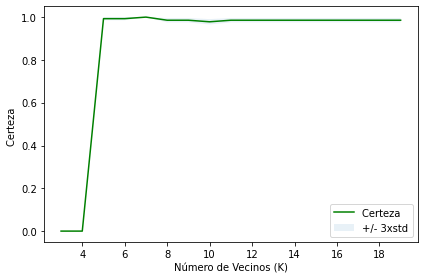

In [459]:
plt.plot(range(3,Ks),mean_acc,'g')
plt.fill_between(range(3,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Certeza ', '+/- 3xstd'))
plt.ylabel('Certeza ')
plt.xlabel('Número de Vecinos (K)')
plt.tight_layout()
plt.show()

In [460]:
print( "La mejor aproximación de certeza fue con ", mean_acc.max(), "con k=", mean_acc.argmax()+1)

La mejor aproximación de certeza fue con  1.0 con k= 5


In [461]:
#Me quedo con el modelo mejor y lo entreno con X e Y train
knn_model = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1)
knn_model.fit(X_train,y_train)

#Hago predicción con X test y lo comparo con y test
ypred = knn_model.predict(X_train)
yhat = knn_model.predict(X_test)
  
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
knn_acc_train = accuracy_score(y_train, ypred)
knn_acc_test = accuracy_score(y_test, yhat)

print("Precisión de entrenamiento: ", knn_acc_train)
print("Precisión de test: ", knn_acc_test)
knn_model


Precisión de entrenamiento:  0.9706959706959707
Precisión de test:  1.0


KNeighborsClassifier()

In [462]:
print(confusion_matrix(y_test, yhat, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat))

[[84  0]
 [ 0 53]]
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        84
           4       1.00      1.00      1.00        53

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137



<a name="id2"></a>
## Arbol de decisión

### Modelado y entrenamiento

In [463]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 4, 9],
                 'max_depth'   : [3, 5, 10],
                 'criterion'   : [ 'entropy','gini']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    modelo = DecisionTreeClassifier(        
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    yhat= modelo.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(7)

Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 9} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 9} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 9} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 9} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 5, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'm

,accuracy,criterion,max_depth,max_features
4,0.985401,entropy,5,4
7,0.985401,entropy,10,4
13,0.985401,gini,5,4
5,0.978102,entropy,5,9
11,0.978102,gini,3,9
8,0.970803,entropy,10,9
10,0.970803,gini,3,4


In [464]:
#Creo el modelo y lo entreno con X e Y train
resultados = resultados.reset_index(drop=True)
dt_model = DecisionTreeClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
dt_model.fit(X_train,y_train)

#Hago predicción con X test y lo comparo con y test
ypred = dt_model.predict(X_train)
yhat2 = dt_model.predict(X_test)
 
#print('Parametros del mejor arbol: ',resultados.at[0,'criterion'],resultados.at[0,'max_depth'],resultados.at[0,'max_features'])    
dt_acc_train = accuracy_score(y_train, ypred)
dt_acc_test = accuracy_score(y_test, yhat2)

print("Precisión de entrenamiento: ", dt_acc_train)
print("Precisión de test: ", dt_acc_test)
dt_model


Precisión de entrenamiento:  0.9835164835164835
Precisión de test:  0.9708029197080292


DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=4)

In [465]:
print(confusion_matrix(y_test, yhat2, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat2))

[[82  2]
 [ 2 51]]
              precision    recall  f1-score   support

           2       0.98      0.98      0.98        84
           4       0.96      0.96      0.96        53

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [466]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': dt_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,UnifSize,0.734423
5,BareNuc,0.094084
3,MargAdh,0.043455
2,UnifShape,0.038414
0,Clump,0.036931
6,BlandChrom,0.028775
4,SingEpiSize,0.013708
7,NormNucl,0.010209
8,Mit,0.000000


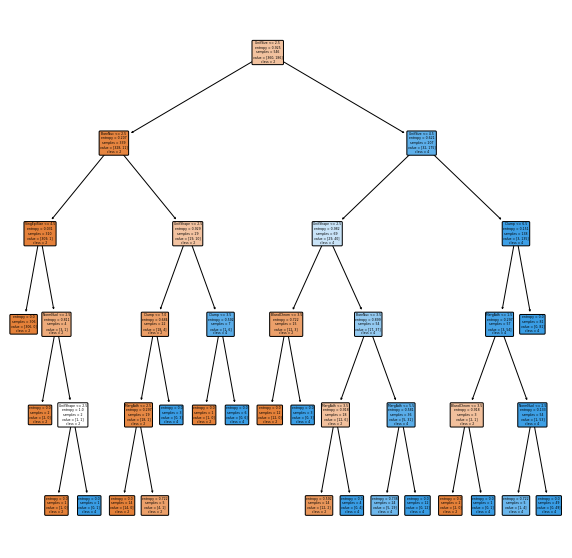

In [467]:
#Preparo las etiquetas del arbol
featureNames = vars_dep
targetNames = sorted(df[y_label].unique().astype('str'))

#Esto Genera bien el fichero .dot
# arbol_dot = tree.export_graphviz(drugTree, out_file='drugtree.dot',
#                                  feature_names=featureNames, class_names=targetNames ,
#                                  filled=True, special_characters=True)  

#Esto pinta bien el arbol, hay que poner antes el tamaño de la figura, sino lo hace muy pequeño
plt.figure(figsize=(10, 10))
plot_tree(dt_model, feature_names=featureNames, class_names=targetNames, filled=True, rounded=True,)
plt.show()

<a name="id3"></a>
## SVM Support Vector Machines 

In [468]:
# Itero con los 4 posibles kernel de SVM para ver cual es el mejor
kernel_params=['linear','poly','rbf','sigmoid']
acc_svm = pd.DataFrame(index=kernel_params)

for i in kernel_params:
    svm_model = svm.SVC(kernel=i)
    svm_model.fit(X_train, y_train)
    yhat3 = svm_model.predict(X_test)
    acc_svm.at[i,'accuracy'] = accuracy_score(y_test, yhat3)

# Extraigo el mejor
mejor_kernel = acc_svm[acc_svm['accuracy']==acc_svm['accuracy'].max()].index
mejor_kernel = np.array(mejor_kernel).astype('str')
print('El mejor kernel es ', mejor_kernel[0],'con una precisión de: ',acc_svm['accuracy'].max())
acc_svm  

El mejor kernel es  rbf con una precisión de:  0.9927007299270073


,accuracy
linear,0.985401
poly,0.963504
rbf,0.992701
sigmoid,0.408759


In [469]:
# Construyo el modelo final con ese Kernel
svm_model = svm.SVC(kernel=mejor_kernel[0])
svm_model.fit(X_train,y_train)


#Hago predicción con X train y test
ypred = svm_model.predict(X_train)
yhat3 = svm_model.predict(X_test)

svm_acc_train = accuracy_score(y_train, ypred)
svm_acc_test = accuracy_score(y_test, yhat3)

print("Precisión de entrenamiento: ", svm_acc_train)
print("Precisión de test: ", svm_acc_test)

svm_model

Precisión de entrenamiento:  0.9743589743589743
Precisión de test:  0.9927007299270073


SVC()

In [470]:
print(confusion_matrix(y_test, yhat3, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat3))

[[84  0]
 [ 1 52]]
              precision    recall  f1-score   support

           2       0.99      1.00      0.99        84
           4       1.00      0.98      0.99        53

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



<a name="id4"></a>
## Regresion Logística

In [13]:
# Itero con los 5 posibles Solver de Reg Logística para ver cual es el mejor
solver_params=['lbfgs','liblinear','sag','saga','newton-cg']
acc_lr = pd.DataFrame(index=solver_params)

for i in solver_params:
    lr_model = LogisticRegression(C=0.01, solver=i)
    lr_model.fit(X_train, y_train)
    y_hat7 = lr_model.predict(X_test)
    acc_lr.at[i,'accuracy'] = accuracy_score(y_test, y_hat7)

# Extraigo el mejor
mejor_solver = acc_lr[acc_lr['accuracy']==acc_lr['accuracy'].max()].index
mejor_solver = np.array(mejor_solver).astype('str')
print('El mejor kernel es ', mejor_solver[0],'con una precisión de: ',acc_lr['accuracy'].max())
acc_lr  


El mejor kernel es  lbfgs con una precisión de:  0.9854014598540146


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,accuracy
lbfgs,0.985401
liblinear,0.941606
sag,0.985401
saga,0.985401
newton-cg,0.985401


In [14]:
# Construyo el modelo final con ese Solver
lr_model = LogisticRegression(C=0.01,solver=mejor_solver[0])
lr_model.fit(X_train, y_train)

#Hago predicción con X train y test
ypred = lr_model.predict(X_train)
yhat4 = lr_model.predict(X_test)

lr_acc_train = accuracy_score(y_train, ypred)
lr_acc_test = accuracy_score(y_test, yhat4)

print("Precisión de entrenamiento: ", lr_acc_train)
print("Precisión de test: ", lr_acc_test)

lr_model

Precisión de entrenamiento:  0.9652014652014652
Precisión de test:  0.9854014598540146


LogisticRegression(C=0.01)

In [473]:
print(confusion_matrix(y_test, yhat4, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat4))

[[84  0]
 [ 2 51]]
              precision    recall  f1-score   support

           2       0.98      1.00      0.99        84
           4       1.00      0.96      0.98        53

    accuracy                           0.99       137
   macro avg       0.99      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137



<a name="id5"></a>
## Random Forest

In [474]:

# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'max_features': [3, 4, 5],
                 'max_depth'   : [3, 10,20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                n_estimators= 100,        
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 10, 'max_features': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 3} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 4} ✓
Modelo: {'criterion': 'gini', 'max_depth': 20, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 5} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 3} ✓
Modelo: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 4} ✓
Modelo: {'criterion': 'entropy', 'max_d

,oob_accuracy,criterion,max_depth,max_features
0,0.963370,gini,10,4
1,0.963370,gini,20,4
2,0.961538,gini,3,3
3,0.961538,entropy,20,3


In [475]:
#Creo el modelo y lo entreno con X e Y train
rf_model = RandomForestClassifier(criterion=resultados.at[0,'criterion'],
                                  max_depth = resultados.at[0,'max_depth'],
                                  max_features = resultados.at[0,'max_features'])
#rf_model = DecisionTreeClassifier(criterion="gini", max_depth = 10, max_features = 5,n_estimators= 100,random_state = 123)
rf_model.fit(X_train,y_train)

#Hago predicción con Y test
ypred = rf_model.predict(X_train)
yhat5 = rf_model.predict(X_test)

rf_acc_train = accuracy_score(y_train, ypred)
rf_acc_test = accuracy_score(y_test, yhat5)

print("Precisión de entrenamiento: ", rf_acc_train)
print("Precisión de test: ", rf_acc_test)

rf_model

Precisión de entrenamiento:  1.0
Precisión de test:  0.9927007299270073


RandomForestClassifier(max_depth=10, max_features=4)

In [476]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': rf_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,UnifShape,0.265739
1,UnifSize,0.258827
5,BareNuc,0.157307
6,BlandChrom,0.139959
0,Clump,0.059708
4,SingEpiSize,0.052861
7,NormNucl,0.037332
3,MargAdh,0.021304
8,Mit,0.006963


In [477]:
print(confusion_matrix(y_test, yhat5, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat5))

[[84  0]
 [ 1 52]]
              precision    recall  f1-score   support

           2       0.99      1.00      0.99        84
           4       1.00      0.98      0.99        53

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



<a name="id6"></a>
## XGBoost

In [479]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100, 500, 1000],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'max_depth'   : [3, 5, 7],
                 'gamma' : [0.1, 0.2]
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    xgb_model = XGBClassifier(
#               use_label_encoder=False,
                verbosity=0,
                ** params
             )
    
    xgb_model.fit(X_train, y_train)
    yhat6= xgb_model.predict(X_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(accuracy_score(y_test,yhat6))
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)
resultados.head(7)

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000} ✓
Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500} ✓


/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Modelo: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000} ✓


,accuracy,gamma,learning_rate,max_depth,n_estimators
0,0.992701,0.1,0.01,5.0,1000.0
1,0.985401,0.1,0.01,3.0,100.0
2,0.985401,0.2,0.05,5.0,500.0
3,0.985401,0.2,0.01,3.0,500.0
4,0.985401,0.2,0.01,3.0,1000.0
5,0.985401,0.2,0.01,5.0,100.0
6,0.985401,0.2,0.01,5.0,500.0


In [480]:
#Creo el modelo y lo entreno con X e Y train
xgb_model = XGBClassifier(n_estimators = resultados.at[0,'n_estimators'].astype('int'),
                          learning_rate = resultados.at[0,'learning_rate'],
                          max_depth = resultados.at[0,'max_depth'].astype('int'),
                          gamma = resultados.at[0,'gamma'])

xgb_model.fit(X_train, y_train)

ypred = xgb_model.predict(X_train)
yhat6 = xgb_model.predict(X_test)

xgb_acc_train = accuracy_score(y_train, ypred)
xgb_acc_test = accuracy_score(y_test, yhat6)

print("Precisión del Arbol de entrenamiento: ", xgb_acc_train)
print("Precisión del Arbol de test: ", xgb_acc_test)
xgb_model

/Users/robertosanzgarcia/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Precisión del Arbol de entrenamiento:  0.9981684981684982
Precisión del Arbol de test:  0.9927007299270073


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [481]:
importancia_predictores = pd.DataFrame(
                            {'predictor': vars_dep,
                             'importancia': xgb_model.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
1,UnifSize,0.606557
2,UnifShape,0.160495
5,BareNuc,0.066274
0,Clump,0.045710
7,NormNucl,0.041087
6,BlandChrom,0.032871
4,SingEpiSize,0.022987
3,MargAdh,0.014374
8,Mit,0.009645


In [482]:
print(confusion_matrix(y_test, yhat6, labels=sorted(df[y_label].unique())))
print (classification_report(y_test, yhat6))

[[84  0]
 [ 1 52]]
              precision    recall  f1-score   support

           2       0.99      1.00      0.99        84
           4       1.00      0.98      0.99        53

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137



In [483]:
Resultado_total = pd.DataFrame(
            {'Algoritmo':('KNN','Decision Tree','SVM','Logistic Regression','Random Forest','XGBoost'),
             'Precisión Entrenam':(knn_acc_train, dt_acc_train, svm_acc_train, lr_acc_train, rf_acc_train, xgb_acc_train),
             'Precisión Test':(knn_acc_test, dt_acc_test, svm_acc_test, lr_acc_test, rf_acc_test, xgb_acc_test),             
            })
Resultado_total.sort_values('Precisión Test', ascending=False)

,Algoritmo,Precisión Entrenam,Precisión Test
0,KNN,0.970696,1.000000
2,SVM,0.974359,0.992701
4,Random Forest,1.000000,0.992701
5,XGBoost,0.998168,0.992701
3,Logistic Regression,0.965201,0.985401
1,Decision Tree,0.983516,0.970803
